In [1]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [2]:
e = exp.load('iter_exps10', experiment_location='experiments', datadir='Mdata')

In [3]:
e.trials_df

,trial_idx,model_name,expt,num_iter,layer1_num_lags,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04+expt06+expt09+expt11,3,2,TconvScaffoldIter0,<experiment.Trial object at 0x7fb09c0bc2e0>,0.100182


In [5]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

array([  0,  35,  63,  86, 111])

In [ ]:
dataset.fnames

In [39]:
#plot.plot_model_weights(e.trials[0].model)

# readout weights

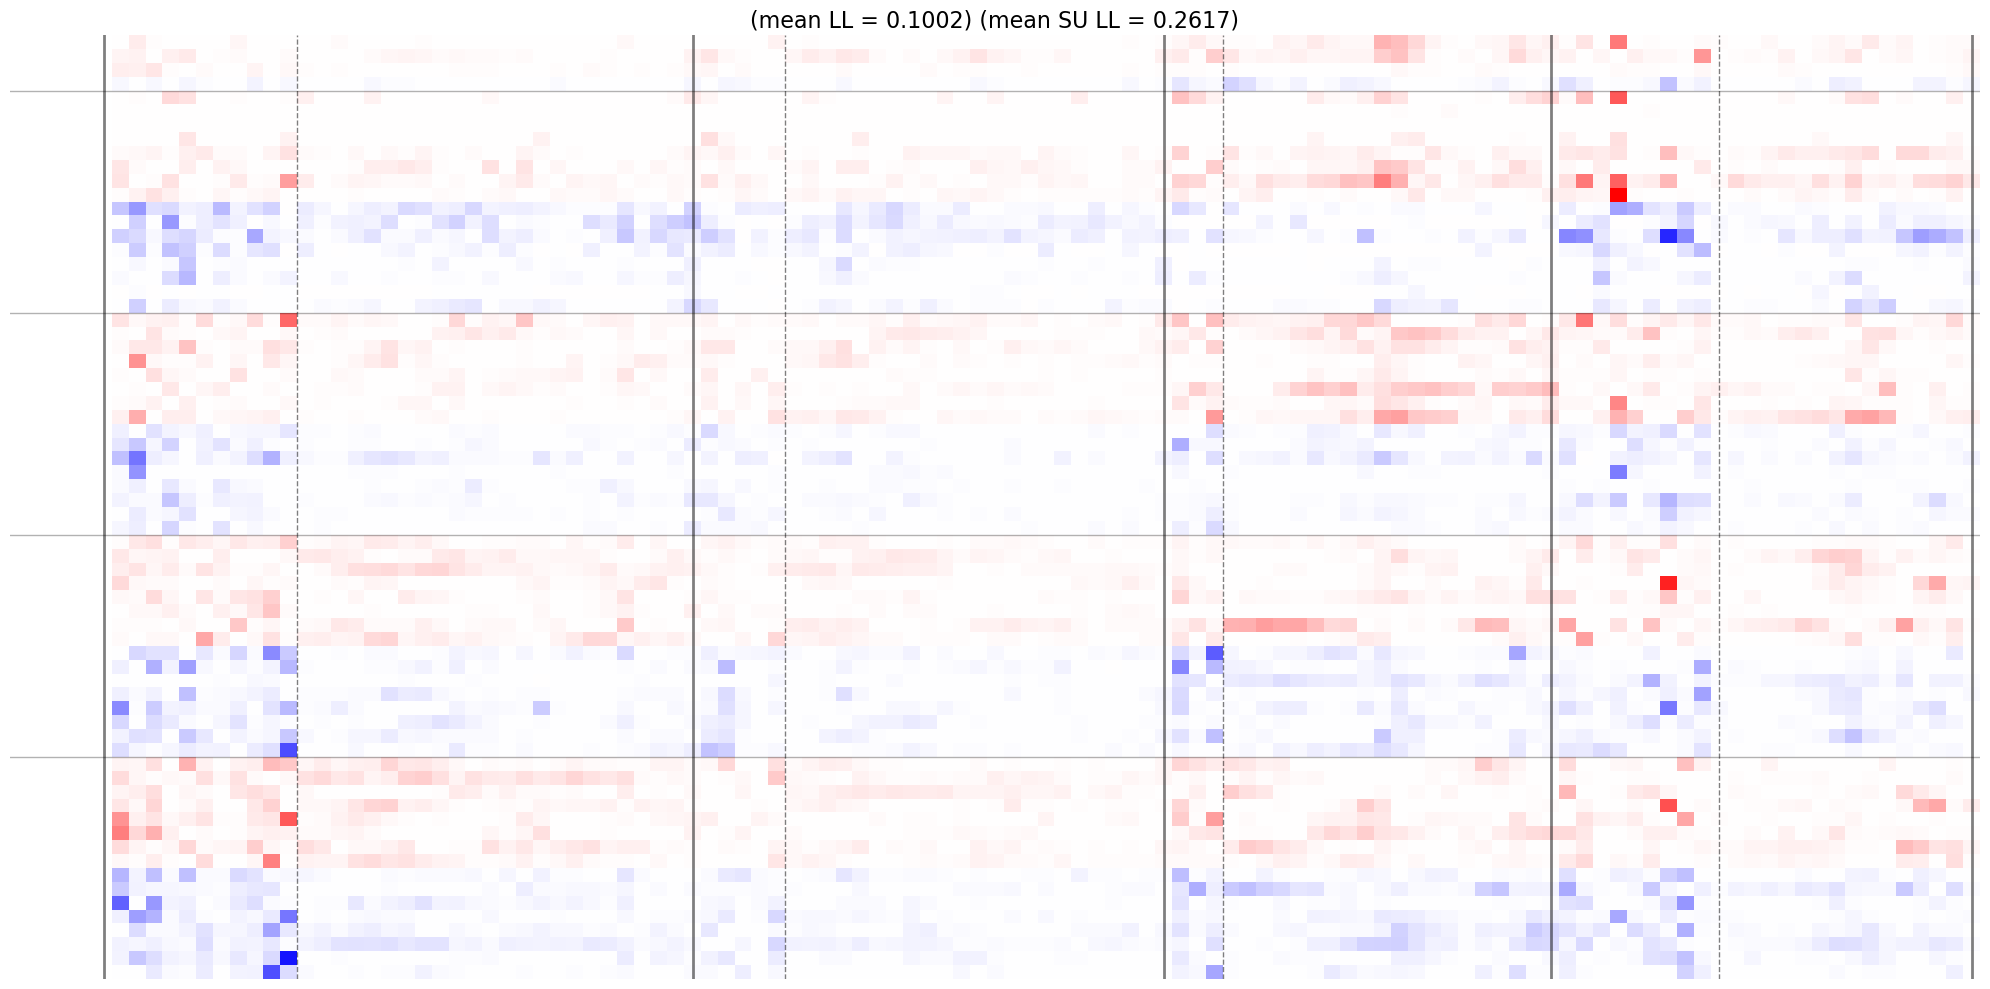

In [116]:
readout_weights = np.sum(e.trials[0].model.networks[1].layers[0].weights[:,:,:], axis=1)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[3,:] = -readout_weights[3,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 4, 20, 36, 52, 68]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

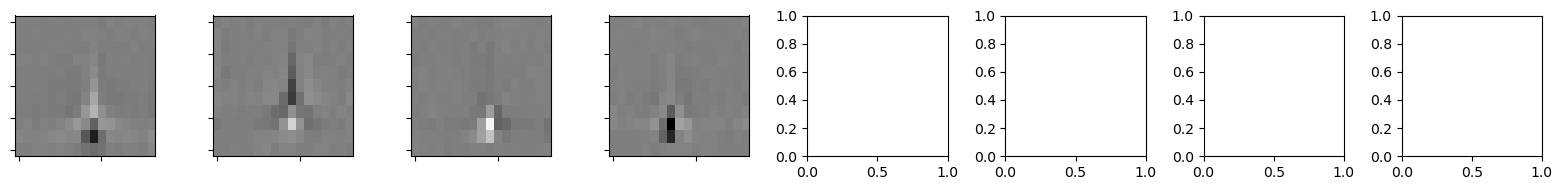

In [7]:
e.trials[0].model.NDN.plot_filters()

In [8]:
e.trials[0].model.NDN.networks[0].layers[2].get_weights().shape

(16, 7, 2, 16)

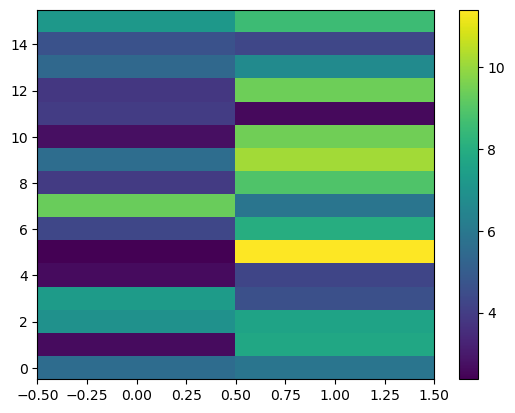

In [10]:
plot.imagesc(np.sum(np.sum(abs(e.trials[0].model.NDN.networks[0].layers[2].get_weights()), axis=1), axis=0))
plt.colorbar()
# higher weights in the second lag,
# indicates temporal processing

# calculate results

In [391]:
dataset.num_lags

[autoreload of predict failed: Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


14

In [11]:
# calculate the results of the model
#pred = e.trials[0].model.NDN(dataset[:dataset.NT, :]['stim'])
batch_size = 100000 #500000

ti = 3
results = []
for nt in range(batch_size, dataset.NT, batch_size):
    print('### Trial', ti, 'Time', nt)
    output = e.trials[0].model.NDN(dataset[nt-batch_size:nt])
    results.append(output.detach().cpu().numpy())

### Trial 3 Time 100000
### Trial 3 Time 200000
### Trial 3 Time 300000
### Trial 3 Time 400000
### Trial 3 Time 500000
### Trial 3 Time 600000
### Trial 3 Time 700000
### Trial 3 Time 800000
### Trial 3 Time 900000
### Trial 3 Time 1000000
### Trial 3 Time 1100000
### Trial 3 Time 1200000
### Trial 3 Time 1300000
### Trial 3 Time 1400000


In [13]:
# concatenate the results
results = np.concatenate(results)

In [16]:
dataset.NT

1494984

# filters

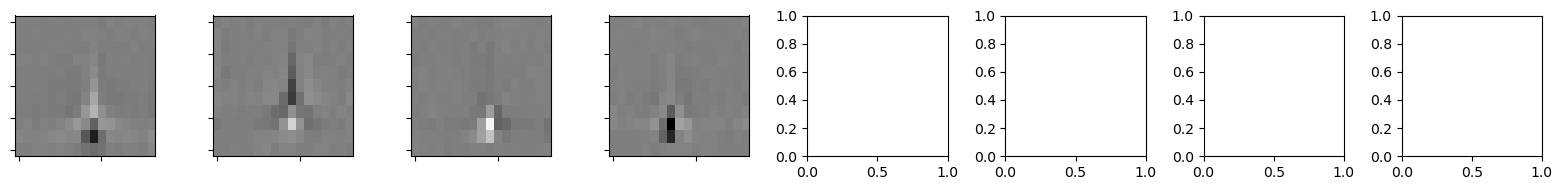

In [337]:
e.trials[0].model.NDN.plot_filters()

# STAs

In [8]:
expts = ['expt04', 'expt06', 'expt09', 'expt11']
# calculate the STA
num_lags = 14
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
pred = (dataset.stim[:1400000].T@results / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
stas = (dataset.stim[:1400000].T@dataset.robs[:1400000] / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
print(stas.shape)

# plot first 6 STAs
for expti in range(len(expt_boundaries)-1):
    fig = plt.figure(figsize=(30, 20))
    fig.suptitle(expts[expti]+': neurons '+str(expt_boundaries[expti])+'-'+str(expt_boundaries[expti+1]))
    i = 0
    for cc in range(expt_boundaries[expti], expt_boundaries[expti+1]):
        expt_len = expt_boundaries[expti+1] - expt_boundaries[expti]
        plt.subplot(expt_len//4+1, 8, i+1)
        plot.imagesc(stas[:, :, cc], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
        plt.title('STA '+str(cc))
        plt.subplot(expt_len//4+1, 8, i+2)
        plot.imagesc(pred[:, :, cc], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
        plt.title('PRD '+str(cc)+', LL = %.4f' % e.trials[0].LLs[cc])
        i += 2


NameError: name 'results' is not defined

# direction-selective cells

In [6]:
dir_cells = [0, 2, 63, 87]

## exitatory/inhibitory weights

In [7]:
# get the weights
readout_weights = e.trials[0].model.networks[1].layers[0].weights
print('Readout weights shape', readout_weights.shape)
readout_weights[2:4,:,:] = -readout_weights[2:4,:,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:,:] = -readout_weights[i:i+8,:,:]
    
readout_max = np.max(readout_weights[:,:,dir_cells])
readout_min = -readout_max

pred_max = np.max(pred[:,:,dir_cells])
pred_min = -pred_max

fig = plt.figure(figsize=(20,10))
rows,cols = 4,4
gridspec = fig.add_gridspec(rows,cols)
# put vertical space between the plots
gridspec.update(wspace=0.2, hspace=0.8)

cc = 0
for cc in range(len(dir_cells)):
    ax = fig.add_subplot(gridspec[cc,0])
    plot.imagesc(pred[:,:,dir_cells[cc]], cmap='gray', ax=ax)
    ax.set_title('Cell '+str(dir_cells[cc])+', LL = %.4f' % e.trials[0].LLs[dir_cells[cc]])
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')
    
    ax = fig.add_subplot(gridspec[cc,1:])
    ax.set_xlabel('Layers')
    ax.set_ylabel('Space')
    ax.set_title('Cell '+str(dir_cells[cc]))
    
    # draw a vertical line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        # shift the line back by 0.5
        ax.axvline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)
        
    cc += 1

Readout weights shape (68, 36, 111)


NameError: name 'pred' is not defined

## projection weights

In [345]:
lgn = e.trials[0].model.networks[0].layers[0].weights
num_filters = e.trials[0].model.networks[0].layers[0].params['num_filters']
input_dims = e.trials[0].model.networks[0].layers[0].params['input_dims']
num_lags = input_dims[3]
input_space = input_dims[1]
num_lags, input_space, lgn.shape, 17*11

(14, 36, (17, 11, 4), 187)

Object `HERE` not found.


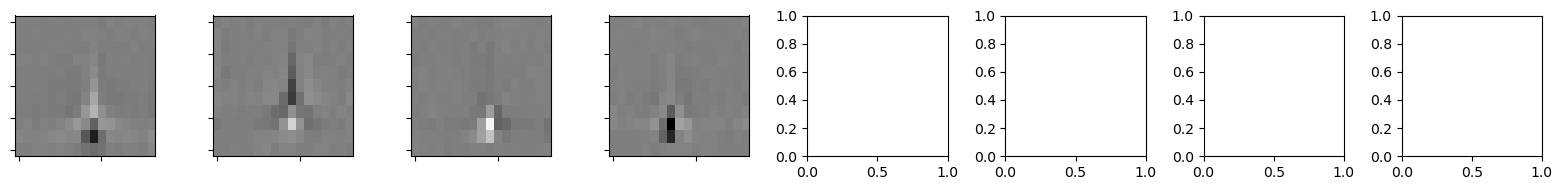

LGN weights shape (17, 11, 4)
Projection weights shape (4, 17, 16)


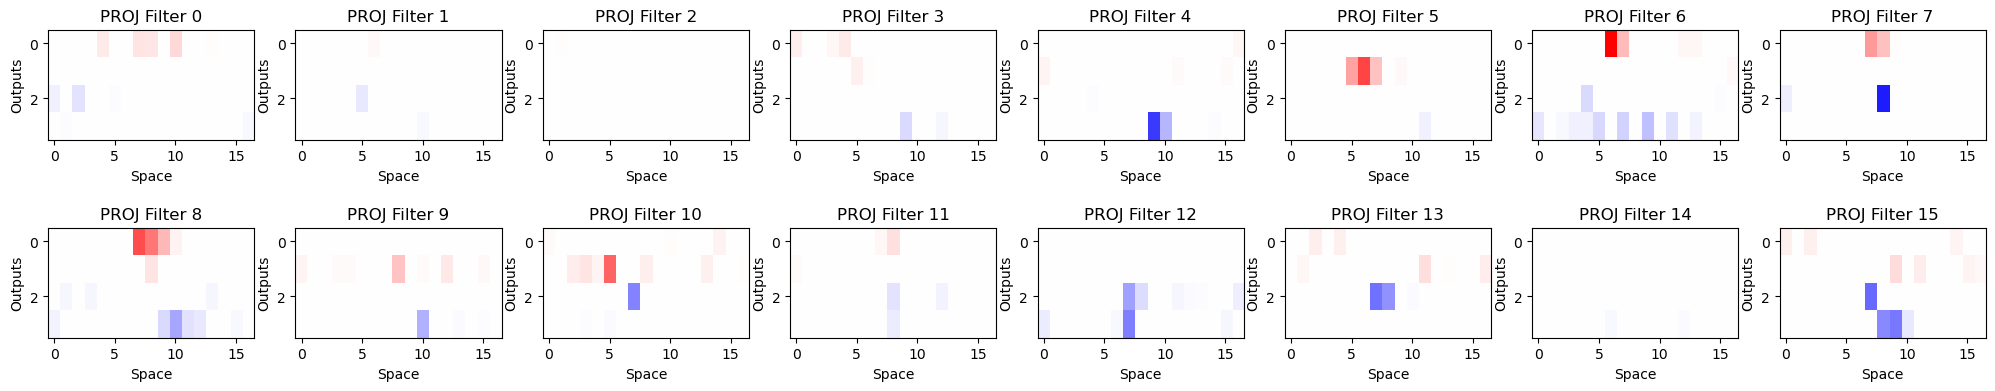

In [339]:
# THIS IS NOTHING, WE CAN'T USE THE WEIGHTS OF THE LGN LAYER HERE?
proj_weights = e.trials[0].model.networks[0].layers[1].weights
proj_weights[2:,:,:] = -proj_weights[2:,:,:]
proj_max = np.max(proj_weights)
proj_min = -proj_max

e.trials[0].model.NDN.plot_filters()
lgn = e.trials[0].model.networks[0].layers[0].weights

print('LGN weights shape', lgn.shape)
print('Projection weights shape', proj_weights.shape)

# make a 2x2 grid
fig = plt.figure(figsize=(25,4))
# put space between the plots
fig.subplots_adjust(wspace=0.2, hspace=0.8)
rows,cols = 2,8
gridspec = fig.add_gridspec(rows,cols)
for i in range(proj_weights.shape[2]):
    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(gridspec[row,col])
    ax.imshow(proj_weights[:,:,i], cmap='bwr', aspect='auto', vmin=proj_min, vmax=proj_max)
    ax.set_title('PROJ Filter '+str(i))
    ax.set_xlabel('Space')
    ax.set_ylabel('Outputs')
plt.show()

# 
# # make a linear approximation of the projection weights by averaging the LGN filters where the weights are
# # for each projection filter, copy the LGN filter to the corresponding output weighted by the projection weights
# 
# # normalize the projection weights
# proj_weights_normalized = proj_weights / abs(np.max(proj_weights))
# 
# proj_filters_exc = np.zeros((16,17,11))
# proj_filters_inh = np.zeros((16,17,11))
# for subunit in range(proj_filters_exc.shape[0]):
#     for space in range(proj_filters_exc.shape[1]):
#         for exc in range(proj_weights.shape[0]//2):
#             proj_filters_exc[subunit, space, :] += lgn[space, :, exc] * proj_weights_normalized[exc, space, subunit]
#         for inh in range(proj_weights.shape[0]//2, proj_weights.shape[0]):
#             proj_filters_inh[subunit, space, :] += lgn[space, :, inh] * proj_weights_normalized[inh, space, subunit]
# 
# exc_max = np.max(proj_filters_exc)
# exc_min = -exc_max
# inh_max = np.max(proj_filters_inh)
# inh_min = -inh_max
# 
# # plot the filters
# fig = plt.figure(figsize=(25,8))
# # put space between the plots
# fig.subplots_adjust(wspace=0.3, hspace=0.8)
# rows,cols = 4,8
# gridspec = fig.add_gridspec(rows,cols)
# i = 0
# for row in range(0, rows, 2):
#     for col in range(cols):
#         ax = fig.add_subplot(gridspec[row,col])
#         ax.imshow(proj_filters_exc[i,:,:].T, cmap='copper', aspect='auto', origin='lower', alpha=0.5, vmin=exc_min, vmax=exc_max)
#         ax.set_title('Exc Filter '+str(i))
#         ax.set_xlabel('Space')
#         ax.set_ylabel('Time')
#         ax = fig.add_subplot(gridspec[row+1,col])
#         ax.imshow(proj_filters_inh[i,:,:].T, cmap='bone', aspect='auto', origin='lower', alpha=0.5, vmin=inh_min, vmax=inh_max)
#         ax.set_title('Inh Filter '+str(i))
#         ax.set_xlabel('Space')
#         ax.set_ylabel('Time')
#         i += 1
# plt.suptitle('Linear Approximation of LGN Filters Weighted by Projection Weights')
# plt.show()

## predictions

In [175]:
# iterate over the timesteps and accumulate predictions for each neuron
preds = {}

batch_size = 100000 #500000

for nt in range(batch_size, dataset.NT, batch_size): #dataset.NT
    print(nt-batch_size, nt)
    results = predict.predict(e.trials[0].model, dataset=dataset[nt-batch_size:nt])
    for ni in dir_cells:
        if ni not in preds:
            preds[ni] = {}
        for pred_i, i in enumerate(range(nt-batch_size,nt)):
            if i not in preds[ni]:
                preds[ni][i] = {}
            for layer_name in results.outputs[pred_i].keys():
                if layer_name not in preds[ni][i]:
                    preds[ni][i][layer_name] = []
                preds[ni][i][layer_name].append(results.outputs[pred_i][layer_name][0])

0 100000
100000 200000
200000 300000
300000 400000
400000 500000
500000 600000
600000 700000
700000 800000
800000 900000
900000 1000000
1000000 1100000
1100000 1200000
1200000 1300000
1300000 1400000


In [195]:
preds[0][0]['core'][0].shape

(1, 576)

In [217]:
import tqdm

# look at what weights are activated when a neuron spikes
nt = 1000 #1400000
neuron = dir_cells[0]
exc_per_layer = np.zeros((5,nt))
inh_per_layer = np.zeros((5,nt))

for i in tqdm.tqdm(range(0, nt)):
    exc_per_layer[0][i] = np.sum(preds[neuron][i]['core'][0][:, 0:2])
    inh_per_layer[0][i] = np.sum(preds[neuron][i]['core'][0][:, 2:4])
    exc_per_layer[1][i] = np.sum(preds[neuron][i]['core'][0][:, 4:12])
    inh_per_layer[1][i] = np.sum(preds[neuron][i]['core'][0][:, 12:20])
    exc_per_layer[2][i] = np.sum(preds[neuron][i]['core'][0][:, 20:28])
    inh_per_layer[2][i] = np.sum(preds[neuron][i]['core'][0][:, 28:36])
    exc_per_layer[3][i] = np.sum(preds[neuron][i]['core'][0][:, 36:44])
    inh_per_layer[3][i] = np.sum(preds[neuron][i]['core'][0][:, 44:52])
    exc_per_layer[4][i] = np.sum(preds[neuron][i]['core'][0][:, 52:60])
    inh_per_layer[4][i] = np.sum(preds[neuron][i]['core'][0][:, 60:68])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 32727.09it/s]


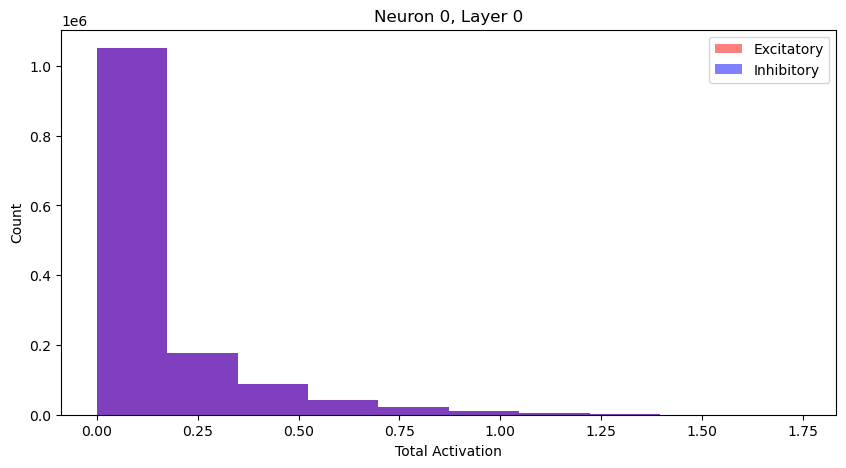

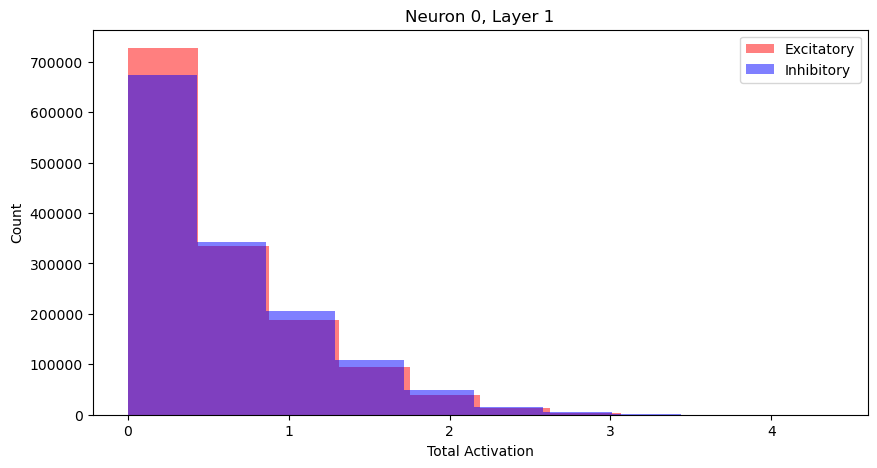

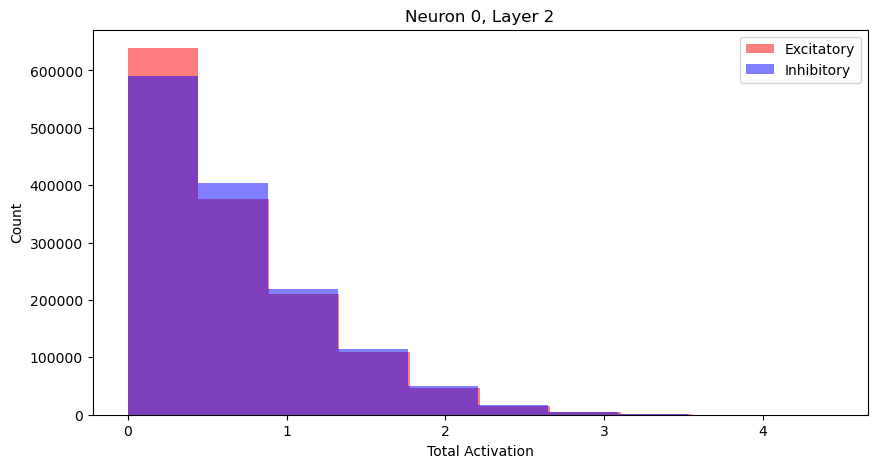

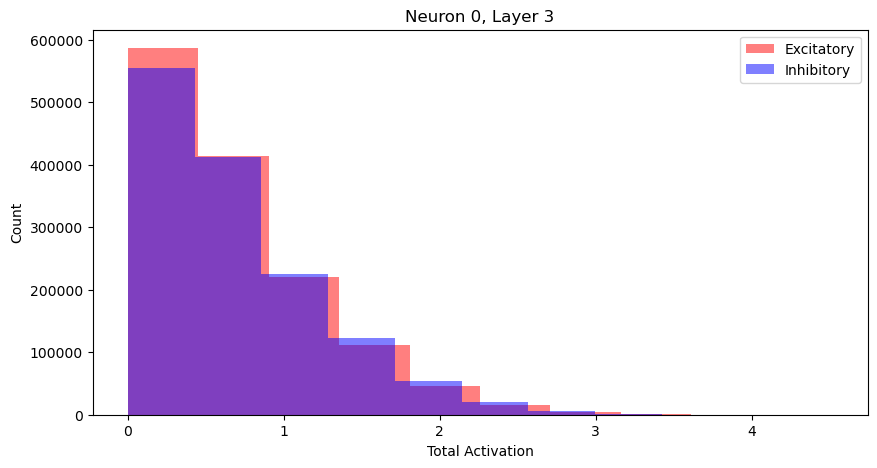

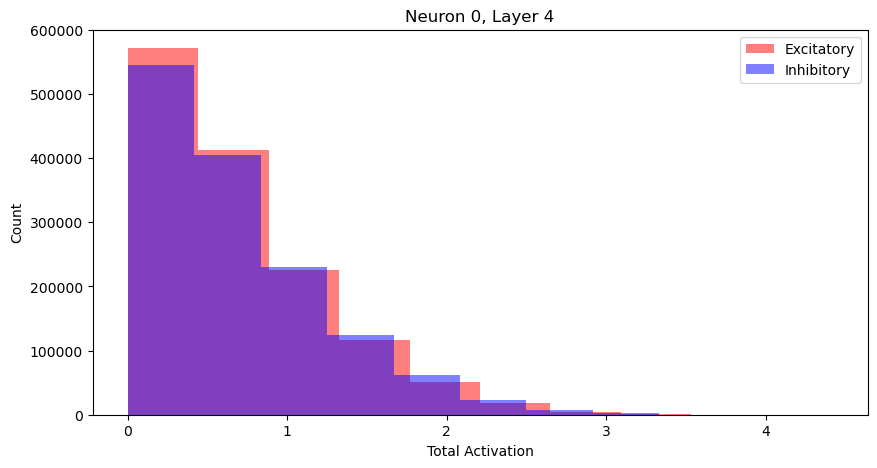

In [212]:
for i in range(5):
    # plot histogram of the excitation vs. inhibition of each layer
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.hist(exc_per_layer[i], color='r', label='Excitatory', alpha=0.5)
    ax.hist(inh_per_layer[i], color='b', label='Inhibitory', alpha=0.5)
    ax.set_xlabel('Total Activation')
    ax.set_ylabel('Count')
    ax.set_title('Neuron '+str(neuron)+', Layer '+str(i))
    ax.legend()

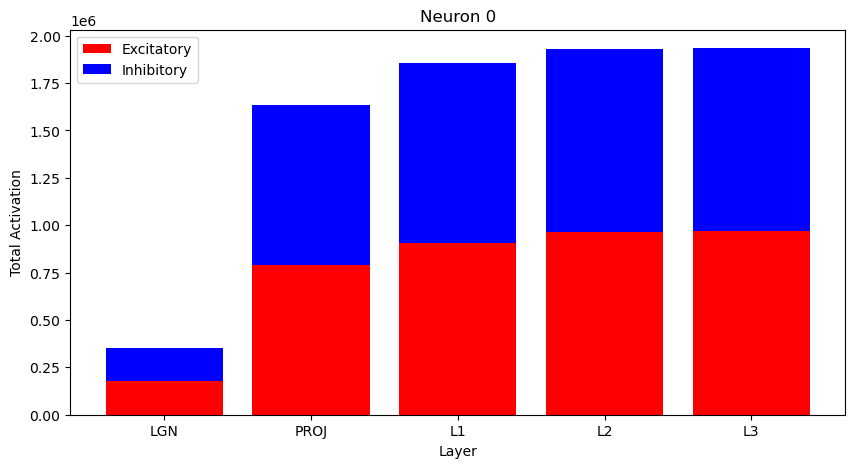

In [215]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(np.arange(5), np.sum(exc_per_layer, axis=1), color='r', label='Excitatory')
ax.bar(np.arange(5), np.sum(inh_per_layer, axis=1), bottom=np.sum(exc_per_layer, axis=1), color='b', label='Inhibitory')
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['LGN', 'PROJ', 'L1', 'L2', 'L3'])
ax.set_xlabel('Layer')
ax.set_ylabel('Total Activation')
ax.set_title('Neuron '+str(neuron))
ax.legend()

## jacobians

In [9]:
neuron = dir_cells[3]
print(neuron)
# find times when this neuron spikes
spike_times = np.where(dataset.robs[:,neuron] > 7)[0]
len(spike_times)

87


16

In [10]:
results = predict.predict(e.trials[0].model, dataset=dataset[spike_times[:2]], 
                          calc_jacobian=True, verbose=True)

num_inps 2
prev_output shape torch.Size([2, 504]) ni 0 NetworkType.scaffold li 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.83it/s]


torch.Size([2, 504]) --> torch.Size([2, 576])
prev_output shape torch.Size([2, 576]) ni 0 NetworkType.scaffold li 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.05it/s]


torch.Size([2, 576]) --> torch.Size([2, 2304])
prev_output shape torch.Size([2, 2304]) ni 0 NetworkType.scaffold li 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


torch.Size([2, 2304]) --> torch.Size([2, 1728])
prev_output shape torch.Size([2, 2448]) ni 1 NetworkType.normal li 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.44it/s]

torch.Size([2, 2448]) --> torch.Size([2, 111])


In [11]:
results.jacobians[1][0].shape

(2, 111, 504)

neuron_weights (68, 36)
torch.Size([2304, 504])
torch.Size([1728, 504])
LGN shape torch.Size([576, 504])
l1_l2_shape (64, 36, 504)
(17, 11, 4)


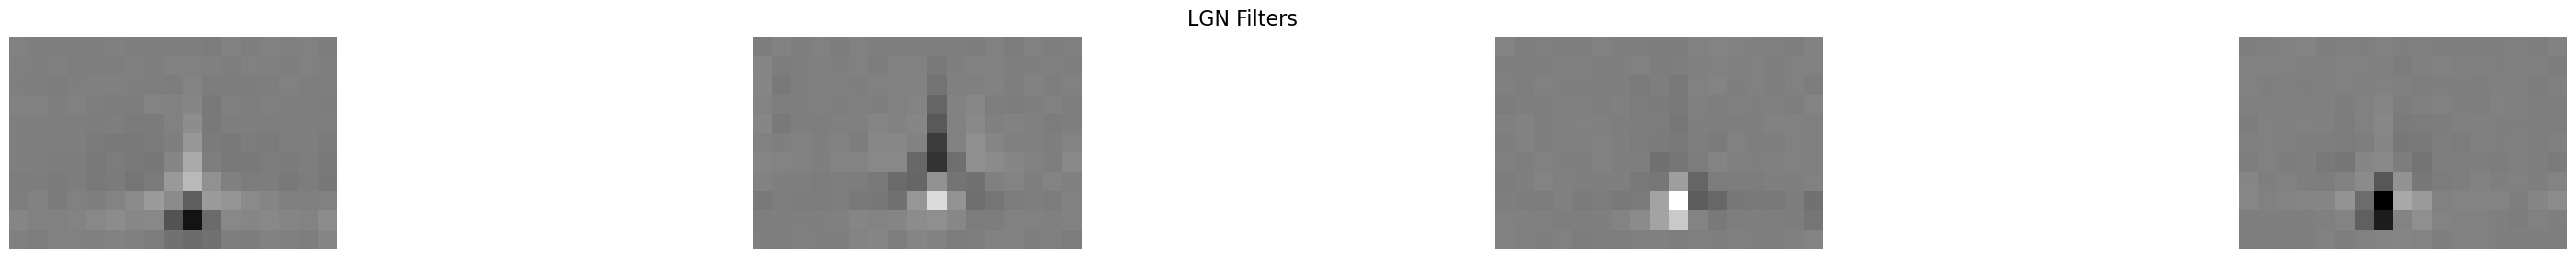

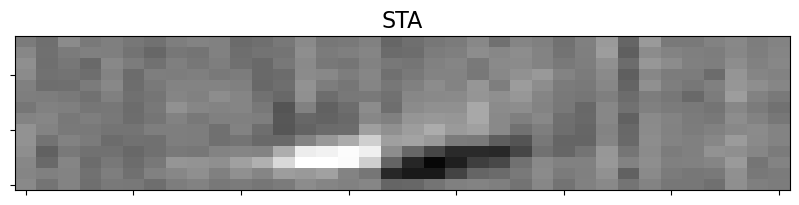

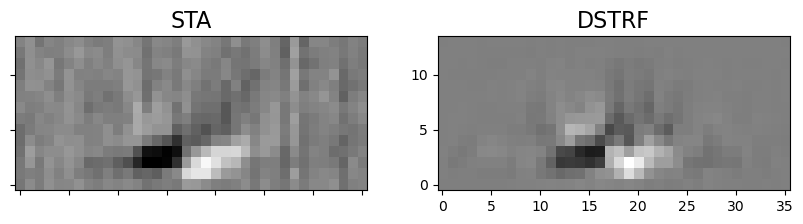

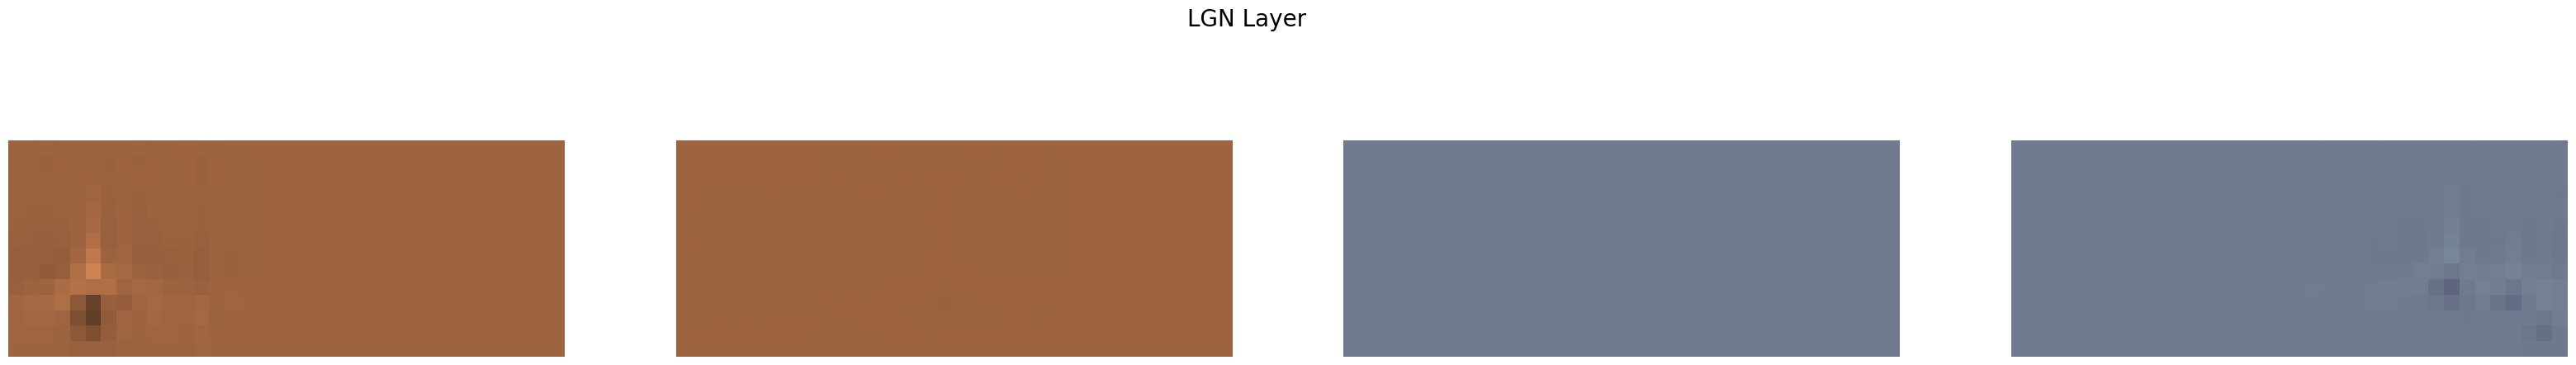

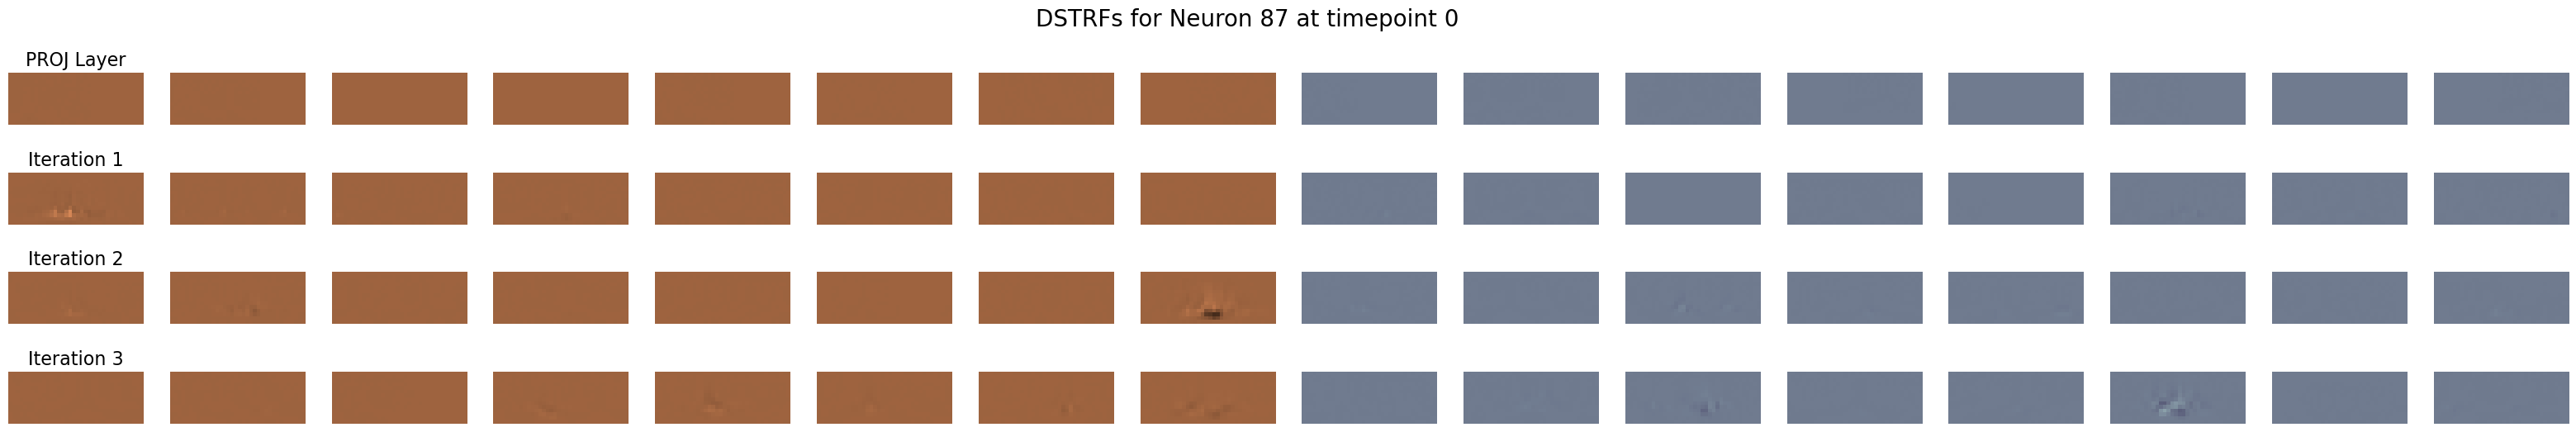

In [359]:
timepoint = 0

filter_max = np.max(e.trials[0].model.networks[0].layers[0].weights)
filter_min = -filter_max

fig = plt.figure(figsize=(40,3))
for i in range(4):
    plt.subplot(1,4,i+1)
    # plot the weights for the first layer
    plt.imshow(e.trials[0].model.networks[0].layers[0].weights[:,:,i].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
    plt.axis('off')
plt.suptitle('LGN Filters', fontsize=16)

neuron_weights = e.trials[0].model.networks[1].layers[0].weights[:,:,neuron]
print('neuron_weights', neuron_weights.shape)

# get the DSTRFs for the layers at timepoint
print(results.jacobians[timepoint]['core'][1].squeeze()[:,:].shape)
print(results.jacobians[timepoint]['core'][2].squeeze()[:,:].shape)

print('LGN shape', results.jacobians[timepoint]['core'][0].squeeze().shape)
l0_reshaped = results.jacobians[timepoint]['core'][0].squeeze()[:144,:].reshape(4,36,504).detach().numpy()
l1_reshaped = results.jacobians[timepoint]['core'][1].squeeze()[:576,:].reshape(16,36,504)
l2_reshaped = results.jacobians[timepoint]['core'][2].squeeze()[:,:].reshape(48,36,504)

# stack l0_reshaped and l1_reshaped along the middle dimension
l1_l2_reshaped = np.concatenate((l1_reshaped, l2_reshaped), axis=0)
print('l1_l2_shape', l1_l2_reshaped.shape)

print(e.trials[0].model.networks[0].layers[0].weights.shape)

# Calculate STA
num_lags = 14
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()

# plot the DSTRFs that correspond to the top subunits
# get all of the subunits linked to this neuron, and label by weight and inhibitory/excitatory

l0max = np.max(l0_reshaped)
l0min = -l0max

l1l2max = np.max(l1_l2_reshaped)
l1l2min = -l1l2max

# normalize the neuron weights
normalized_neuron_weights = neuron_weights / np.max(neuron_weights)

fig = plt.figure(figsize=(10,2))
plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray', colrow=True, axis_labels=False)
plt.title('STA', fontsize=16)
# plot DSTRF for the neuron 1
fig = plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
plt.title('STA', fontsize=16)
plt.subplot(1,2,2)
plot.imagesc(results.jacobian[timepoint,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')
plt.title('DSTRF', fontsize=16)

# plot the LGN filters
fig = plt.figure(figsize=(40,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    if i > 1:
        cmap = 'bone'
    else:
        cmap = 'copper'

    # get a weighted sum of the l0_l1_reshaped and the neuron_weights at this neuron
    # # skip the first 4 going to the LGN
    weighted_jacobian = neuron_weights[i,:].T @ l0_reshaped[i,:,:]

    plt.imshow(weighted_jacobian.reshape(36,14).T, cmap=cmap, origin='lower', vmin=l0min, vmax=l0max)
    plt.axis('off')

_ = plt.suptitle('LGN Layer', fontsize=20)


fig = plt.figure(figsize=(40,6))
for i in range(64):
    plt.subplot(4,16,i+1)

    if i/16 - i//16 >= 0.5:
        cmap = 'bone'
    else:
        cmap = 'copper'

    # get a weighted sum of the l0_l1_reshaped and the neuron_weights at this neuron
    # # skip the first 4 going to the LGN
    weighted_jacobian = neuron_weights[i+4,:].T @ l1_l2_reshaped[i,:,:]

    plt.imshow(weighted_jacobian.reshape(36,14).T, cmap=cmap, origin='lower', vmin=l1l2min, vmax=l1l2max)
    plt.axis('off')

    # label each row with the layer it is in
    if i/16 == 0:
        plt.title('PROJ Layer', fontsize=16)
    elif i/16 == 1:
        plt.title('Iteration 1', fontsize=16)
    elif i/16 == 2:
        plt.title('Iteration 2', fontsize=16)
    elif i/16 == 3:
        plt.title('Iteration 3', fontsize=16)
    # elif i/12 == 4:
    #     plt.title('Iteration 4', fontsize=16)
    # elif i/12 == 5:
    #     plt.title('Iteration 5', fontsize=16)

_ = plt.suptitle('DSTRFs for Neuron {}'.format(neuron) + ' at timepoint {}'.format(timepoint), fontsize=20)

# if i/12 - i//12 >= 0.5:
#     # inhibitory
#     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(0,0,weight))
# else:
#     # excitatory
#     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(weight,0,0))

In [260]:
290304/4/36

2016.0

In [240]:
e.trials[0].model.NDN.networks[0].layers[2].input_dims, e.trials[0].model.NDN.networks[0].layers[2].output_dims

([16, 36, 1, 4], [48, 36, 1, 1])

# cell 87

neuron_weights (68, 36)
torch.Size([2304, 504])
torch.Size([1728, 504])
LGN shape torch.Size([576, 504])
l1_l2_shape (64, 36, 504)
(17, 11, 4)


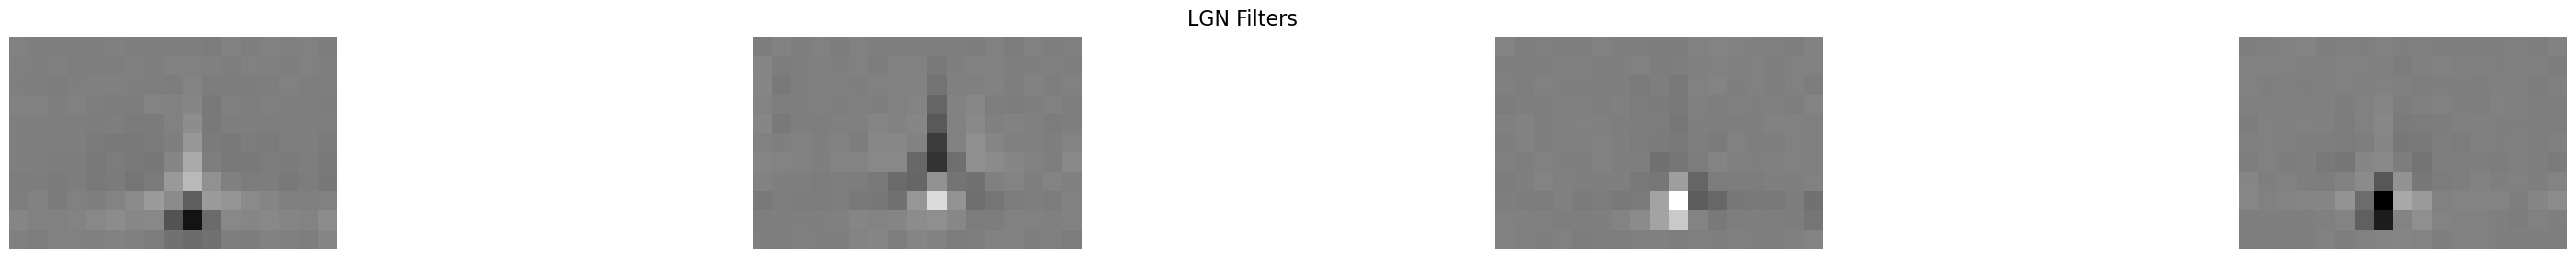

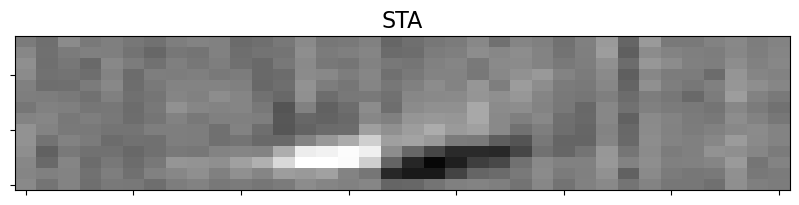

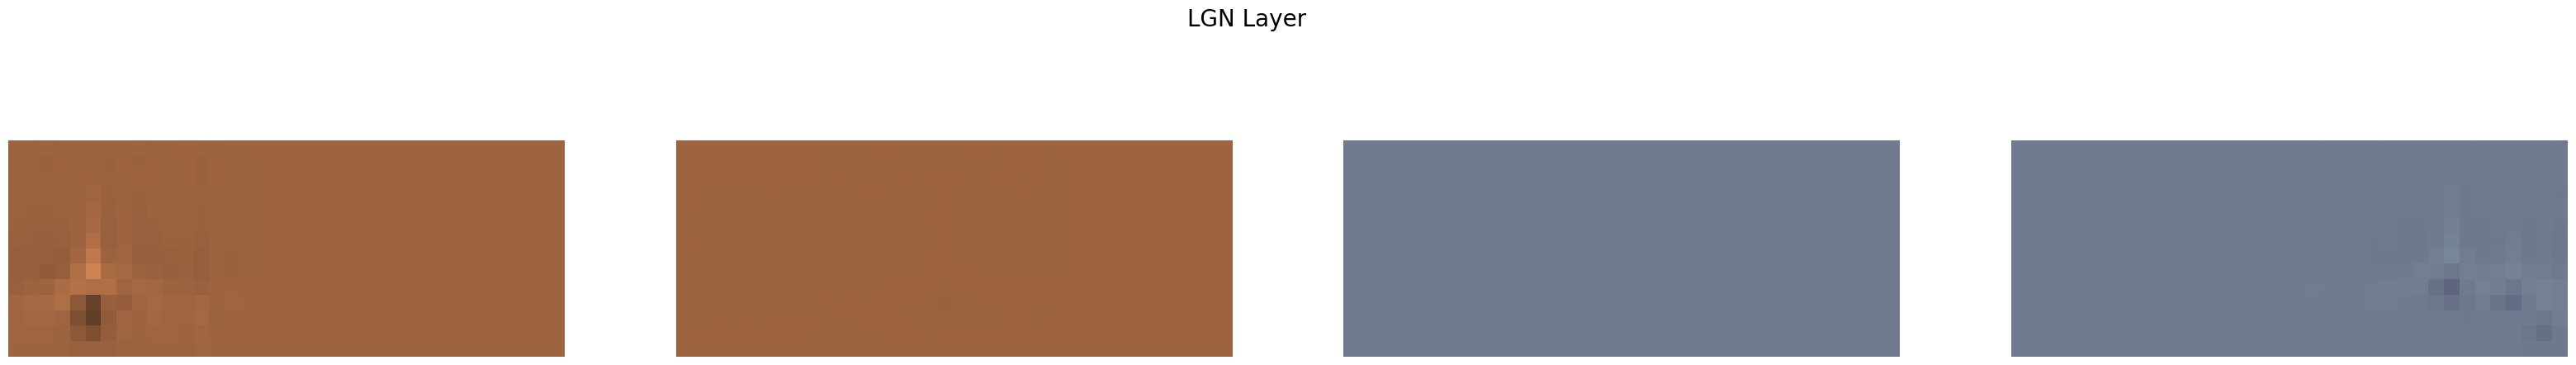

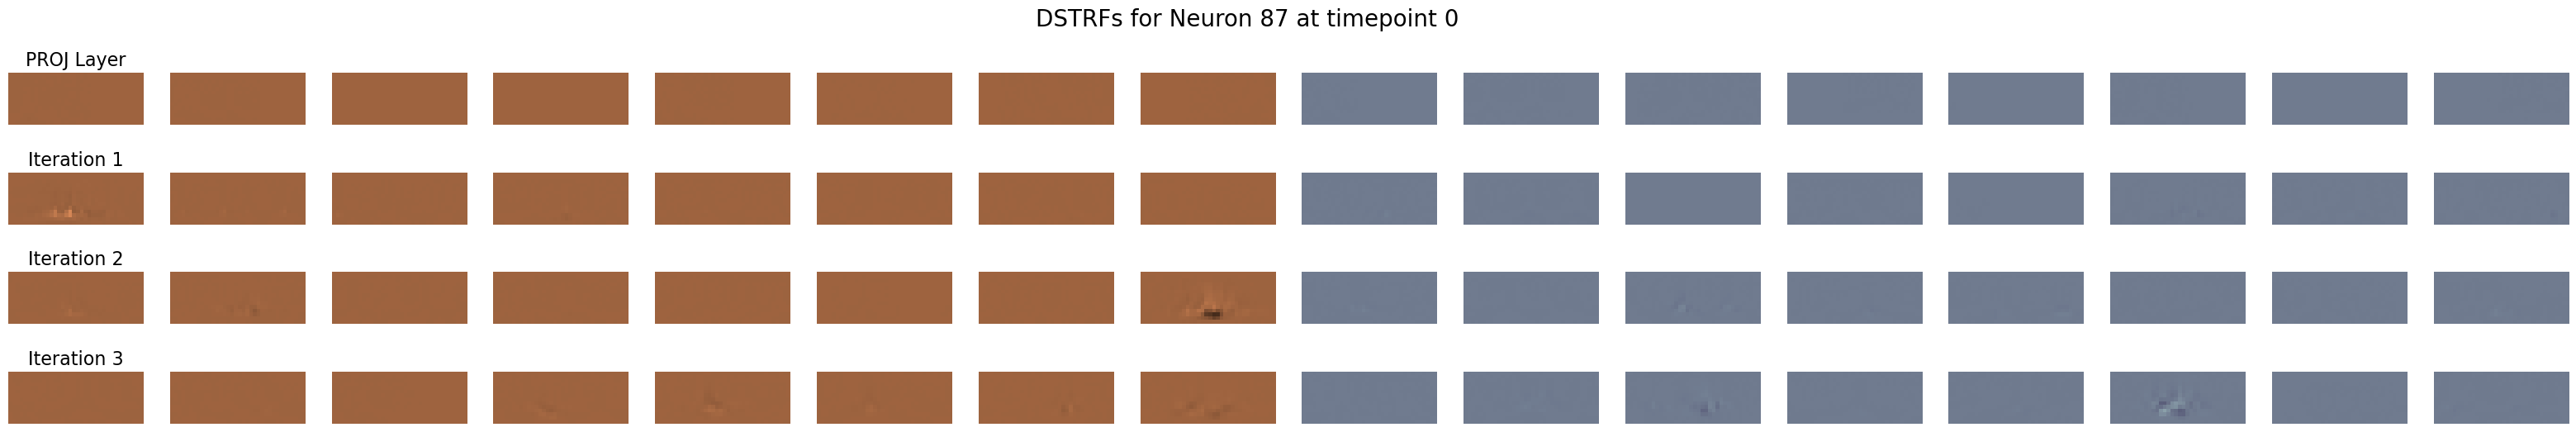

In [346]:
timepoint = 0

filter_max = np.max(e.trials[0].model.networks[0].layers[0].weights)
filter_min = -filter_max

fig = plt.figure(figsize=(40,3))
for i in range(4):
    plt.subplot(1,4,i+1)
    # plot the weights for the first layer
    plt.imshow(e.trials[0].model.networks[0].layers[0].weights[:,:,i].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
    plt.axis('off')
plt.suptitle('LGN Filters', fontsize=16)

neuron_weights = e.trials[0].model.networks[1].layers[0].weights[:,:,neuron]
print('neuron_weights', neuron_weights.shape)

# get the DSTRFs for the layers at timepoint
print(results.jacobians[timepoint]['core'][1].squeeze()[:,:].shape)
print(results.jacobians[timepoint]['core'][2].squeeze()[:,:].shape)

print('LGN shape', results.jacobians[timepoint]['core'][0].squeeze().shape)
l0_reshaped = results.jacobians[timepoint]['core'][0].squeeze()[:144,:].reshape(4,36,504).detach().numpy()
l1_reshaped = results.jacobians[timepoint]['core'][1].squeeze()[:576,:].reshape(16,36,504)
l2_reshaped = results.jacobians[timepoint]['core'][2].squeeze()[:,:].reshape(48,36,504)

# stack l0_reshaped and l1_reshaped along the middle dimension
l1_l2_reshaped = np.concatenate((l1_reshaped, l2_reshaped), axis=0)
print('l1_l2_shape', l1_l2_reshaped.shape)

print(e.trials[0].model.networks[0].layers[0].weights.shape)

# Calculate STA
num_lags = 14
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()

# plot the DSTRFs that correspond to the top subunits
# get all of the subunits linked to this neuron, and label by weight and inhibitory/excitatory

l0max = np.max(l0_reshaped)
l0min = -l0max

l1l2max = np.max(l1_l2_reshaped)
l1l2min = -l1l2max

# normalize the neuron weights
normalized_neuron_weights = neuron_weights / np.max(neuron_weights)

fig = plt.figure(figsize=(10,2))
plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray', colrow=True, axis_labels=False)
plt.title('STA', fontsize=16)

# plot the LGN filters
fig = plt.figure(figsize=(40,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    if i > 1:
        cmap = 'bone'
    else:
        cmap = 'copper'

    # get a weighted sum of the l0_l1_reshaped and the neuron_weights at this neuron
    # # skip the first 4 going to the LGN
    weighted_jacobian = neuron_weights[i,:].T @ l0_reshaped[i,:,:]

    plt.imshow(weighted_jacobian.reshape(36,14).T, cmap=cmap, origin='lower', vmin=l0min, vmax=l0max)
    plt.axis('off')

_ = plt.suptitle('LGN Layer', fontsize=20)


fig = plt.figure(figsize=(40,6))
for i in range(64):
    plt.subplot(4,16,i+1)

    if i/16 - i//16 >= 0.5:
        cmap = 'bone'
    else:
        cmap = 'copper'

    # get a weighted sum of the l0_l1_reshaped and the neuron_weights at this neuron
    # # skip the first 4 going to the LGN
    weighted_jacobian = neuron_weights[i+4,:].T @ l1_l2_reshaped[i,:,:]

    plt.imshow(weighted_jacobian.reshape(36,14).T, cmap=cmap, origin='lower', vmin=l1l2min, vmax=l1l2max)
    plt.axis('off')

    # label each row with the layer it is in
    if i/16 == 0:
        plt.title('PROJ Layer', fontsize=16)
    elif i/16 == 1:
        plt.title('Iteration 1', fontsize=16)
    elif i/16 == 2:
        plt.title('Iteration 2', fontsize=16)
    elif i/16 == 3:
        plt.title('Iteration 3', fontsize=16)
    # elif i/12 == 4:
    #     plt.title('Iteration 4', fontsize=16)
    # elif i/12 == 5:
    #     plt.title('Iteration 5', fontsize=16)

_ = plt.suptitle('DSTRFs for Neuron {}'.format(neuron) + ' at timepoint {}'.format(timepoint), fontsize=20)

# if i/12 - i//12 >= 0.5:
#     # inhibitory
#     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(0,0,weight))
# else:
#     # excitatory
#     plt.title('Unit {} '.format(i) + '[{:.2f}]'.format(weight), fontsize=12, color=(weight,0,0))